# Exploring data from DSCOVR EPIC Level 2 Aerosol Version 3

Visualizing the spatial transport and temporal variations of UV Aerosol Index (UVAI). The figures from this notebook were included in the poster ["Impact of Canadian Wildfires on Mid Atlantic’s Region Air Quality: An Analysis Using ASDC Data" (A41O-2864)](https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1316563) presented at the 2023 American Geophysical Union (AGU) Fall Meeting.

Note that operations that save the figures are commented out, and so will need to be uncommented in order to save new figures.

- Created: 2023 August 29
- Last Modified: 2023 December 18
- Author: Daniel Kaufman <daniel.kaufman@nasa.gov>

### Import Required Packages

In [1]:
import json
import os
import re
import time
from datetime import datetime
from glob import glob
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from numpy import ma
from tqdm.notebook import tqdm

# For the timeseries section
import json
from scipy import spatial

# For the timeseries section, to compare with EPA Air Quality data
import pyrsig

# Fot the animation section
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter

## Dataset

"DSCOVR_EPIC_L2_AER_03 is the Deep Space Climate Observatory (DSCOVR) Enhanced Polychromatic Imaging Camera (EPIC) Level 2 UV Aerosol Version 3 data product. Observations for this data product are at 340 and 388 nm and are used to derive near UV (ultraviolet) aerosol properties. The EPIC aerosol retrieval algorithm (EPICAERUV) uses a set of aerosol models to account for the presence of carbonaceous aerosols from biomass burning and wildfires (BIO), desert dust (DST), and sulfate-based (SLF) aerosols. These aerosol models are identical to those assumed in the OMI (Ozone Monitoring Instrument) algorithm (Torres et al., 2007; Jethva and Torres, 2011)." ([Source](https://asdc.larc.nasa.gov/project/DSCOVR/DSCOVR_EPIC_L2_AER_03))

This requires the data granules from [DSCOVR EPIC Level-2](https://cmr.earthdata.nasa.gov/search/concepts/C1962643459-LARC_ASDC.html) to have been downloaded into a local directory.

## Set file paths

Modify the following cell to specify the local directory where the data granules reside.

In [2]:
data_dir = Path("/Users/dkaufma3/projects/wildfires_study/2_ExperimentFolder/data/dscovr").resolve()

In [3]:
pattern = re.compile(r"DSCOVR_EPIC_L2_AER_03_([0-9]+)_03")  # the capture group is a datetime timestamp

file_list = list(data_dir.glob("DSCOVR_EPIC_L2_AER_*.he5"))
num_files = len(file_list)

In [4]:
data_fields_path = 'HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields'
geolocations_path = 'HDFEOS/SWATHS/Aerosol NearUV Swath/Geolocation Fields'

# Wrangling data into Zarr stores

In this section, the netCDF files are converted to Zarr stores to enable faster access and data manipulation later in the notebook.

In [5]:
def convert_nc_to_xrds(filepath: Path, group_path: str) -> xr.Dataset:
    """Converts a netCDF4 group into an xarray Dataset with an added time dimension

    Parameters
    ----------
    filepath : pathlib.Path
        The path to a DSCOVR EPIC netCDF file
    group_path : str
        The internal path to a group, e.g., 'HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields'
    """
    # The filename's datetime string is converted into a datetime timestamp
    timestamp = pattern.findall(str(fp.stem))[0]
    timestamp_dt = datetime.strptime(timestamp, "%Y%m%d%H%M%S")
    
    with nc.Dataset(filepath) as ds:
        grp = ds[group_path]

        # The netCDF4 group is converted into an xarray Dataset object, and then
        #     a new singleton 'time' dimension is added to the Dataset with the timestamp as its only value.
        grp_ds = (
            xr.open_dataset(xr.backends.NetCDF4DataStore(grp))
            .expand_dims(time=[timestamp_dt], axis=0)
        )

    return grp_ds

**!!! Warning !!! This next cell can take a long time.  It needs to be run once, but then should be commented-out if the zarr files already exist.**

In [6]:
# print("Extracting groups...")

# idcs_to_do = range(0, len(file_list))
# for idx in tqdm(idcs_to_do, total=len(idcs_to_do)):
#     fp = file_list[idx]
#     (
#         convert_nc_to_xrds(fp, data_fields_path)
#         .rename({"phony_dim_0": "XDim",
#                  "phony_dim_1": "YDim",
#                  "phony_dim_2": "nLayers",
#                  "phony_dim_3": "nWave3" ,
#                  "phony_dim_4": "nWave2"})
#     ).merge(
#         (convert_nc_to_xrds(fp, geolocations_path)
#          .rename({"phony_dim_5": "XDim",
#                   "phony_dim_6": "YDim"})
#         )
#     ).to_zarr(f"test_zarr_3_{idx:03}.zarr")
    
#     # if idx > 2:
#     #     break
# print("Done extracting groups.")

Now let's open the dataset.  This may take around 30 seconds or so.

In [7]:
mfds = xr.open_mfdataset(glob("test_zarr_3_*.zarr"), 
                         engine='zarr', combine='by_coords')
mfds

<xarray.Dataset>
Dimensions:                         (time: 341, XDim: 2048, YDim: 2048,
                                     nLayers: 5, nWave3: 3, nWave2: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2023-06-01T00:08:31...
Dimensions without coordinates: XDim, YDim, nLayers, nWave3, nWave2
Data variables: (12/36)
    AIRSCO_Flags                    (time, XDim, YDim) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    AIRSL3COvalue                   (time, XDim, YDim) float32 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    AerosolAbsOpticalDepthVsHeight  (time, XDim, YDim, nLayers, nWave3) float32 dask.array<chunksize=(1, 256, 512, 2, 1), meta=np.ndarray>
    AerosolCorrCloudOpticalDepth    (time, XDim, YDim) float32 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    AerosolOpticalDepthOverCloud    (time, XDim, YDim, nWave3) float32 dask.array<chunksize=(1, 512, 512, 1), meta=np.ndarray>
    AerosolOpticalDepthVsHeight     (time, XDim, YDim, nLayers, nWave3) float32 dask.array<chunksize=(1, 256, 512, 2, 1), meta=np.ndarray>
    ...                              ...
    SurfaceAlbedo                   (time, XDim, YDim, nWave2) float32 dask.array<chunksize=(1, 512, 512, 1), meta=np.ndarray>
    SurfaceType                     (time, XDim, YDim) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    TerrainPressure                 (time, XDim, YDim) float32 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    UVAerosolIndex                  (time, XDim, YDim) float32 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    ViewingZenithAngle              (time, XDim, YDim) float32 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    Wavelength                      (time, nWave3) float32 dask.array<chunksize=(1, 3), meta=np.ndarray>

In [8]:
mfds['Longitude'].shape

(341, 2048, 2048)

# Creating static figures

Here we make a slight modification to the ["turbo" colormap](https://blog.research.google/2019/08/turbo-improved-rainbow-colormap-for.html) for improved visualization.

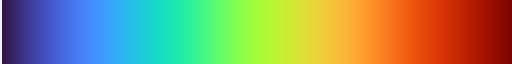

In [9]:
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

# Add a white 'under' color to the turbo colormap
turbo_cm = colormaps.get_cmap('turbo')
newcolors = turbo_cm(np.linspace(0, 1, 256))
silver_color = np.array([0.95, 0.95, 0.95, 1])
newcolors[0, :] = silver_color
my_turbo = ListedColormap(newcolors)
my_turbo

The spatial domain for which we will visualize the data is now defined.

In [10]:
extent = [-141, -50, 32, 72]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# This utility function will simplify some code blocks later.
def get_geo_mask(lon, lat):
    lon_mask = (lon > extent[0]) & (lon < extent[1])
    lat_mask = (lat > extent[2]) & (lat < extent[3])
    return lon_mask & lat_mask

The data variable chosen here will be used for all the figures to follow.

In [11]:
# Choose the data variable here.
data_variable = "UVAerosolIndex"

In [12]:
# This utility function will simplify some code blocks later.
def get_data_arrays(a_timestep: int):
    geo_mask = get_geo_mask(mfds['Longitude'][a_timestep, :, :], mfds['Latitude'][a_timestep, :, :]).compute().values
    lon_values = mfds['Longitude'][a_timestep, :, :].where(geo_mask).values
    lat_values = mfds['Latitude'][a_timestep, :, :].where(geo_mask).values
    var_values = mfds[data_variable][a_timestep, :, :].where(geo_mask).values
    timestamp = datetime.strptime(
        np.datetime_as_string(mfds['time'][a_timestep].values, unit='ms'),
        "%Y-%m-%dT%H:%M:%S.%f"
    )

    # Replace any +inf or -inf values with NaN.
    var_values[np.isinf(var_values)] = np.nan

    return lon_values, lat_values, var_values, timestamp

## Make map of a single timestep

Now let's pick a timestep to visualize.  First print out the timestep indices and their values so we can choose one. 

In [13]:
for i, x in enumerate(mfds['time']):
    print(f"{i} -- {x.values}")

0 -- 2023-06-01T00:08:31.000000000
1 -- 2023-06-01T01:13:58.000000000
2 -- 2023-06-01T02:19:25.000000000
3 -- 2023-06-01T03:24:52.000000000
4 -- 2023-06-01T04:30:19.000000000
5 -- 2023-06-01T05:35:46.000000000
6 -- 2023-06-01T06:41:13.000000000
7 -- 2023-06-01T07:46:40.000000000
8 -- 2023-06-01T08:52:08.000000000
9 -- 2023-06-01T09:57:35.000000000
10 -- 2023-06-01T11:03:02.000000000
11 -- 2023-06-01T12:08:30.000000000
12 -- 2023-06-01T13:13:57.000000000
13 -- 2023-06-01T14:19:24.000000000
14 -- 2023-06-01T15:24:51.000000000
15 -- 2023-06-01T16:30:19.000000000
16 -- 2023-06-01T17:35:46.000000000
17 -- 2023-06-01T18:41:13.000000000
18 -- 2023-06-01T19:46:40.000000000
19 -- 2023-06-01T20:52:08.000000000
20 -- 2023-06-01T21:57:35.000000000
21 -- 2023-06-01T23:03:03.000000000
22 -- 2023-06-02T00:27:13.000000000
23 -- 2023-06-02T01:32:40.000000000
24 -- 2023-06-02T02:38:07.000000000
25 -- 2023-06-02T03:43:34.000000000
26 -- 2023-06-02T04:49:01.000000000
27 -- 2023-06-02T05:54:28.000000000
28

In [14]:
# Choose the timestep here.
timestep = 53

Get the data arrays for the selected timestep

In [15]:
geo_mask = get_geo_mask(mfds['Longitude'][timestep, :, :], mfds['Latitude'][timestep, :, :]).compute().values

lon_values = mfds['Longitude'][timestep, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep, :, :].where(geo_mask).values
timestamp = datetime.strptime(
    np.datetime_as_string(mfds['time'][timestep].values, unit='ms'),
    "%Y-%m-%dT%H:%M:%S.%f"
)

In [16]:
# Get value range for the single timestep
values_min = 0  # Alternatively, one could use `np.nanmin(var_values)`.
values_max = 10
print(f"{values_min} to {values_max}")

0 to 10


In [17]:
# country boundaries
country_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale="110m", facecolor='none', edgecolor='k')

# province boundaries
provinc_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale="110m", facecolor='none', edgecolor='k')

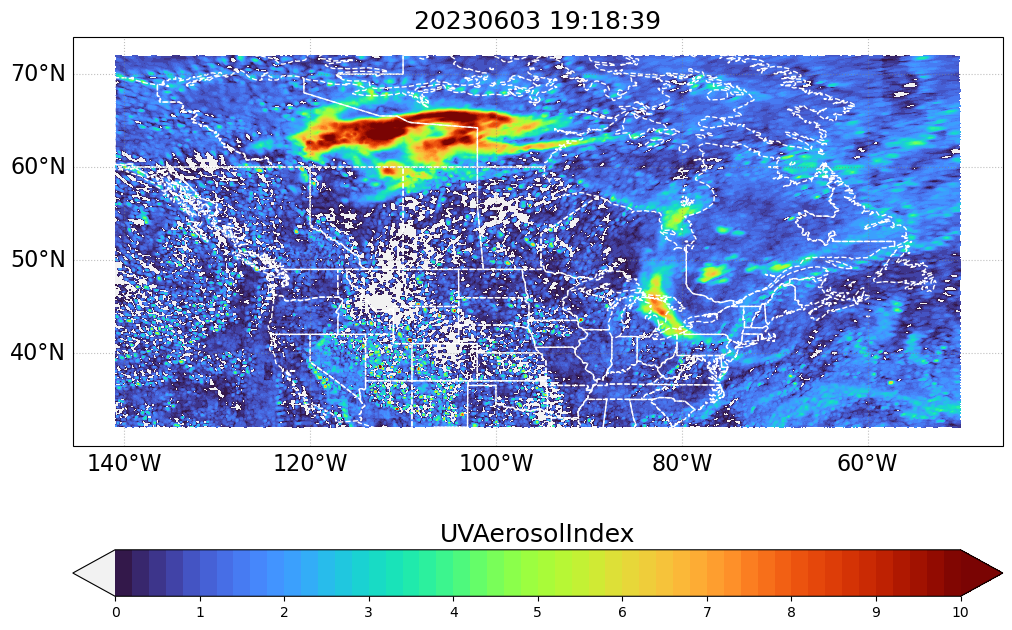

In [18]:
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=my_turbo,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


# plt.savefig("UVAI-%s" % timestamp.strftime("%Y%m%d%H%M%S"), bbox_inches="tight")
plt.show()

### Make the same map but with masked values

Here we specify the UVAI threshold for which we will cut off the values.

In [19]:
mx = ma.masked_array(var_values, mask=(var_values < 4))

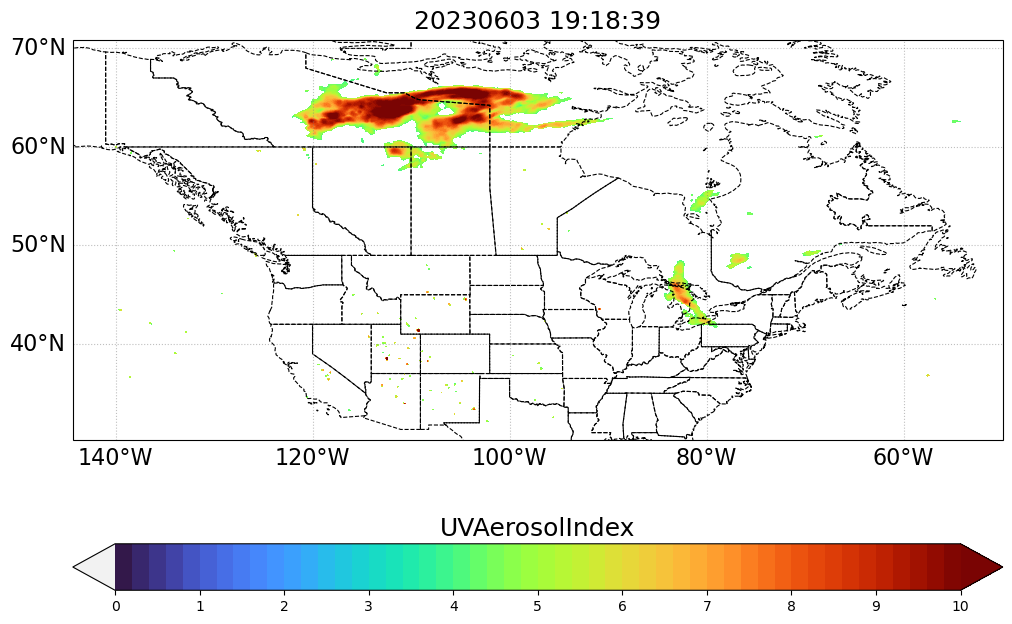

In [20]:
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, mx,
                        cmap=my_turbo,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=0.8, edgecolor="k")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


plt.show()

## Make multi-panel figure of three timesteps

i - 93
i - 116
i - 139


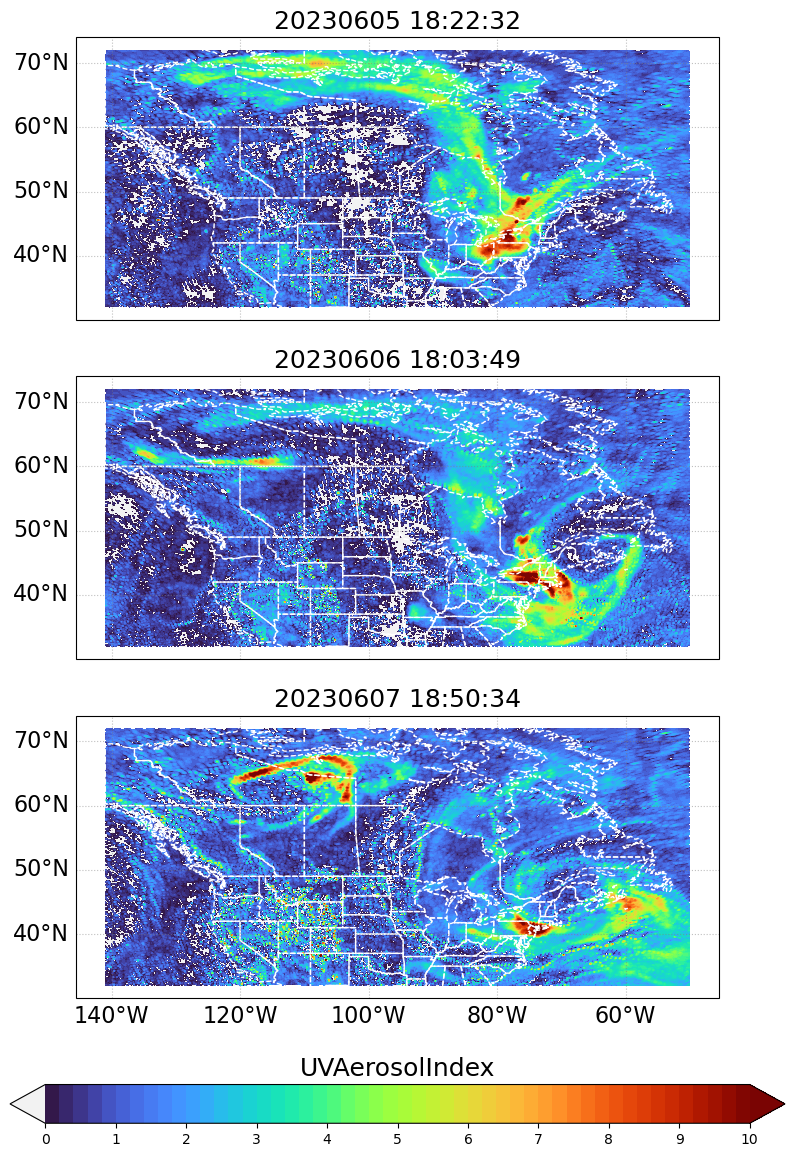

In [21]:
my_projection = ccrs.PlateCarree()

fig, axs = plt.subplots(figsize=(10, 16), nrows=3, sharex=True, sharey=True,
                        subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)


timesteps = [93, 116, 139]
for i, (ax, ts) in enumerate(zip(axs, timesteps)):
    print(f"i - {ts}")
    lon_values, lat_values, var_values, timestamp_str = get_data_arrays(ts)
    _contourf = ax.contourf(lon_values, lat_values, var_values,
                            cmap=my_turbo,  transform=ccrs.PlateCarree(),
                            levels=level_boundaries,
                            vmin=vmin, vmax=vmax, extend='both')
    
    ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")
    
    ax.set_title(
        "%s" % (timestamp_str.strftime("%Y%m%d %H:%M:%S")), fontsize=18
    )
    
    if i < 2:
        grid_labels_locations = ['left']
    else:
        grid_labels_locations = ['left', 'bottom']
        
    gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=grid_labels_locations, 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')
    
    # We change the fontsize tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}

cb_handle = fig.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=axs,
    pad=0.07
)
cb_handle.ax.set_title(data_variable, fontsize=18)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)

# plt.savefig("UVAI-multiple.png", bbox_inches="tight", dpi=250)
plt.show()

## Make a timeseries figure

#### Find point to represent Manhattan

In [22]:
times = [datetime.strptime(np.datetime_as_string(t.values, unit='ms'), "%Y-%m-%dT%H:%M:%S.%f")
         for t in mfds['time']]

n_time = len(mfds.time)

In [23]:
def get_manhattan_value(a_timestep: int, query_point_lon_lat: tuple):
    lon_values, lat_values, var_values, timestamp = get_data_arrays(a_timestep)

    lon_flat, lat_flat = lon_values.flatten(), lat_values.flatten()
    new2d = np.zeros((len(lon_flat), 2))
    for idx, (a, b) in enumerate(zip(lon_flat, lat_flat)):
        if not np.isnan(a):
            new2d[idx, :] = [a, b]

    nearestpt_distance, nearestpt_index = spatial.KDTree(new2d).query(query_point_lon_lat)

    nearestpt_coords = new2d[nearestpt_index, :]

    return nearestpt_distance, nearestpt_index, nearestpt_coords

**!!! Warning !!! This next cell can take a long time (e.g., +20 minutes).  It needs to be run once, but then should be commented-out.**

In [24]:
# # 40.7831° N, 73.9712° W
# pt_manhattan = [-73.9712, 40.7831]

# nearestpt_distances = []
# nearestpt_indices = []
# nearestpt_coords = []
# for i in tqdm(range(n_time)):
#     nearest_distance, nearest_index, nearest_coords = get_manhattan_value(i, pt_manhattan)
#     nearestpt_distances.append(nearest_distance)
#     nearestpt_indices.append(nearest_index)
#     nearestpt_coords.append(nearest_coords)

# # Now save the results to JSON files so you don't have to run this again
# with open("nearestpt_distances.json", "w") as fp:
#     json.dump(nearestpt_distances, fp)
# with open("nearestpt_indices.json", "w") as fp:
#     json.dump([int(i) for i in nearestpt_indices], fp)
# with open("nearestpt_coords.json", "w") as fp:
#     json.dump([[i[0], i[1]] for i in nearestpt_coords], fp)

Load the values stored during execution of the previous cell.

In [25]:
with open("nearestpt_distances.json", "r") as fp:
    nearestpt_distances = json.load(fp)
with open("nearestpt_indices.json", "r") as fp:
    nearestpt_indices = json.load(fp)
with open("nearestpt_coords.json", "r") as fp:
    nearestpt_coords = json.load(fp)

In this next cell, we extract the actual data values at the indices belonging to the point closest to Manhattan. This cell takes just a few minutes.

In [26]:
timeseries_values = []
for i in tqdm(range(n_time)):
    _, _, var_values, timestamp = get_data_arrays(i)
    nearestpt_var_value = var_values.flatten()[nearestpt_indices[i]]
    timeseries_values.append(nearestpt_var_value)

  0%|          | 0/341 [00:00<?, ?it/s]

### Generate figure for DSCOVR EPIC

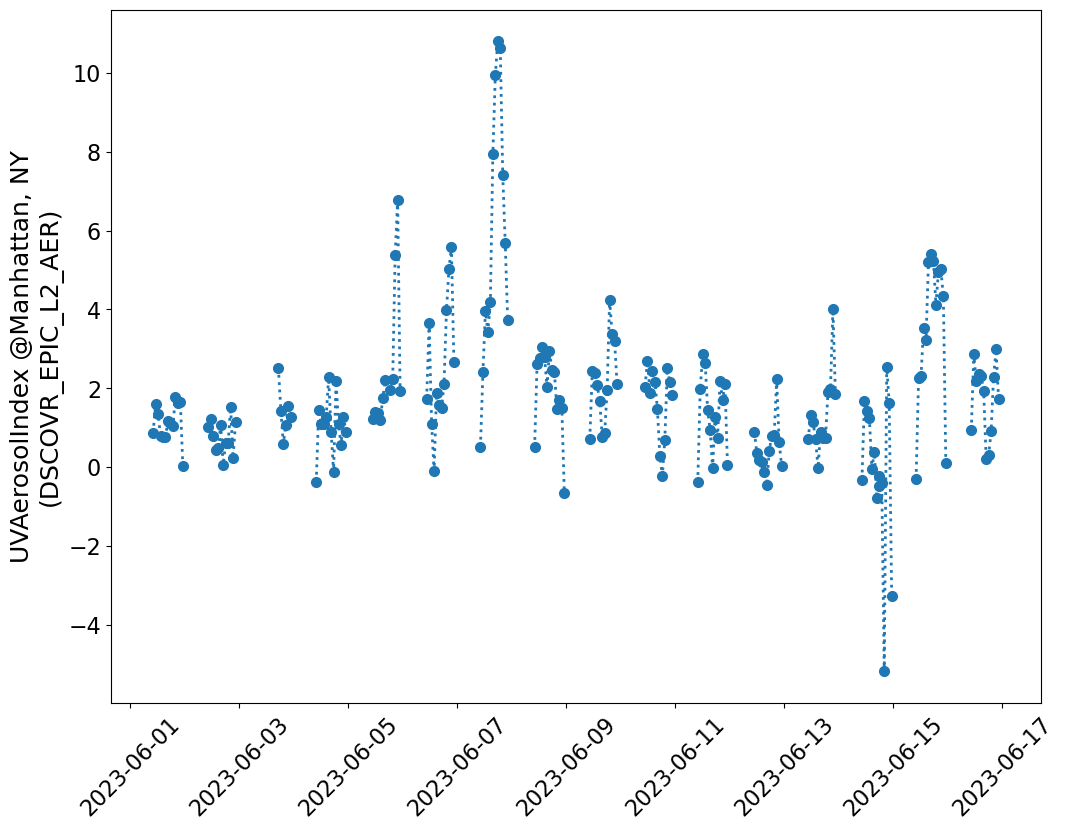

In [27]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(times, timeseries_values, ":o", markersize=7, linewidth=2)

ax.set_ylabel(f"{data_variable} @Manhattan, NY\n(DSCOVR_EPIC_L2_AER)", fontsize=18)
# ax.set_ylim((-10, 10))

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)

# plt.savefig("dscovr_epic_uvai_timeseries_20230601-20230617.png", 
#             dpi=200, bbox_inches="tight")
plt.show()

### Use RSIG to get EPA Air Quality data from the same time period

In [28]:
rsigapi = pyrsig.RsigApi(
    bdate='2023-06-01 00', 
    edate='2023-06-17 23:59:59',
    bbox=(-74.05, 40.68, -73.8, 40.90) #Manhattan
)

aqsno2df = rsigapi.to_dataframe('aqs.pm25', parse_dates=True, unit_keys=False)
aqsno2s = aqsno2df.groupby(['time']).median(numeric_only=True)['pm25']

Using cached: ./aqs.pm25_2023-06-01T000000Z_2023-06-17T235959Z.csv.gz


### Make combined figure

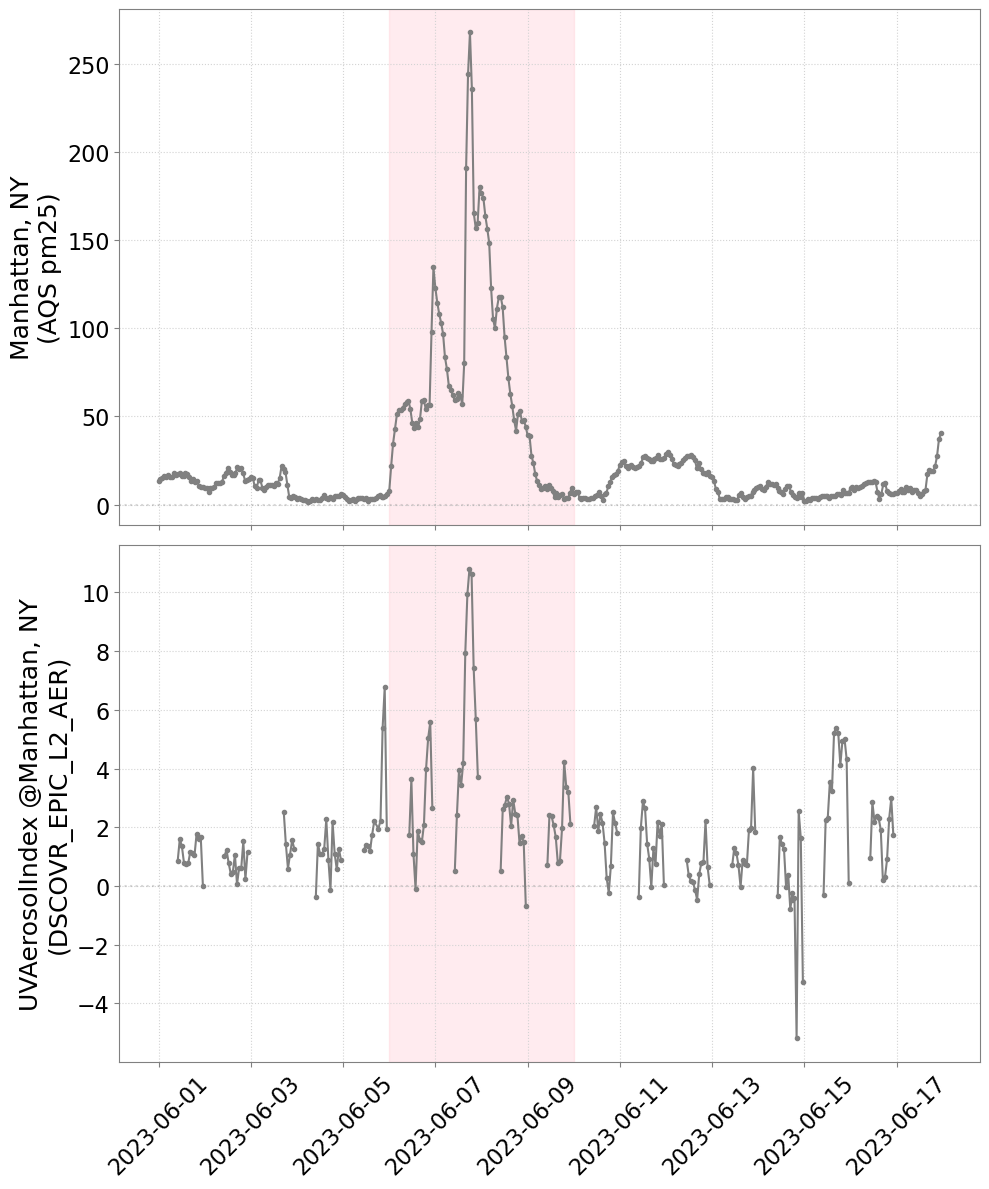

In [29]:
fig, axs = plt.subplots(figsize=(10, 12), nrows=2, ncols=1, sharex=True)

# Plot
# tax = ax.twinx()
axn = 0
axs[axn].plot(
    aqsno2s.index.values, aqsno2s.values, "-o", markersize=3, color='gray'
)
axs[axn].set_ylabel(f"Manhattan, NY\n(AQS pm25)", fontsize=18, color='k')

axn = 1
axs[axn].plot(
    times, timeseries_values, "-o", markersize=3, color="gray"
)
axs[axn].set_ylabel(f"{data_variable} @Manhattan, NY\n(DSCOVR_EPIC_L2_AER)", fontsize=18, color="black")

# Change the aesthetics
for a in axs:
    a.axvspan(datetime(2023, 6, 6, 0, 0, 0), 
              datetime(2023, 6, 10, 0, 0, 0), 
              alpha=0.3, color='pink')
    a.axhline(0, linestyle=":", alpha=0.3, color="gray")
    
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=16)
    a.grid(visible=True, which='major', axis='both', color="lightgray", linestyle=":")

    a.tick_params(color='gray', labelcolor='black')
    for spine in a.spines.values():
        spine.set_edgecolor('gray')

plt.xticks(rotation=45)
plt.tight_layout()

# plt.savefig("dscovr_epic_uvai_with_AQS_timeseries_20230601-20230617.png", 
#             dpi=200, bbox_inches="tight")
plt.show()

# Creating an animation

In [30]:
# Get overall min and max
overall_geo_mask = get_geo_mask(mfds['Longitude'], mfds['Latitude']).compute().values

overall_var_values = mfds[data_variable].where(overall_geo_mask).values

# overall_values_min = np.nanmin(overall_var_values)
# overall_values_max = np.nanmax(overall_var_values[overall_var_values != np.inf])
overall_values_min = 0
overall_values_max = 10
print(f"{overall_values_min} to {overall_values_max}")

0 to 10


/var/folders/4x/brq9v8td00l23t0tsmy_vsw80000gp/T/ipykernel_69039/565891392.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in _contourf.collections:


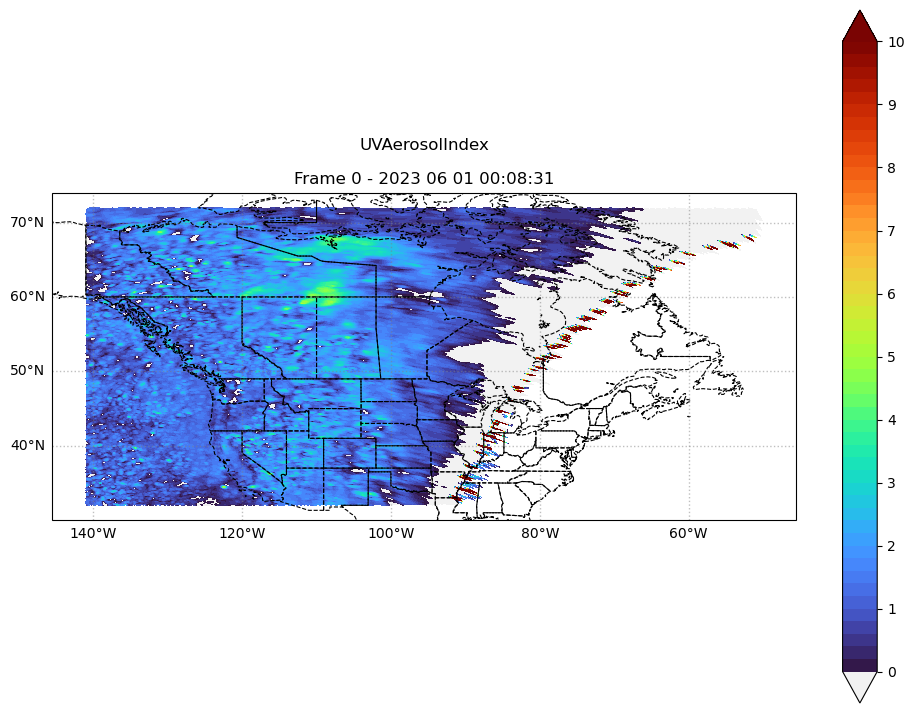

In [31]:
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": ccrs.PlateCarree()})

vmin, vmax = overall_values_min, overall_values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# first image on screen
lon_values, lat_values, var_values, timestamp = get_data_arrays(0)
_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=my_turbo, transform=ccrs.PlateCarree(),
                        levels=level_boundaries, extend='both',
                        vmin=vmin, vmax=vmax)

plt.colorbar(
        _contourf,
        ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
        boundaries=level_boundaries,
        values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
        ax=ax
    )

# ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--', linewidth=0.8, edgecolor="k")
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
                 linewidth=1, color='gray', alpha=0.5, linestyle=':')

# animation function
def animate(i):
    global _contourf

    lon_values, lat_values, var_values, timestamp = get_data_arrays(i)

    for c in _contourf.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    
    _contourf = ax.contourf(lon_values, lat_values, var_values,
                            cmap=my_turbo, transform=ccrs.PlateCarree(),
                            levels=level_boundaries, extend='both',
                            vmin=vmin, vmax=vmax)
    
    ax.set_title("%s\n\nFrame %s - %s" % 
                (data_variable, str(i), timestamp.strftime("%Y %m %d %H:%M:%S")))
    return _contourf

n_frames = 53
ani = FuncAnimation(fig, animate, repeat=False, frames=n_frames, )    

# ani.save('UVAI_latest.gif', writer='imagemagick', fps=2, progress_callback=lambda i, n: print(f"{i:03}/{n_frames}"))

END of Notebook.